In [1]:
import os
os.environ["HF_DIFFUSERS_CACHE"] = "/root/autodl-tmp"
os.environ["no_proxy"] = "localhost,127.0.0.1,modelscope.com,aliyuncs.com,tencentyun.com,wisemodel.cn"
os.environ["http_proxy"] = "http://172.20.0.113:12798"
os.environ["https_proxy"] = "http://172.20.0.113:12798"
os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"
os.environ["SSL_CERT_FILE"] = "/etc/ssl/certs/ca-certificates.crt"

In [2]:
%matplotlib widget
import argparse
import gc
import random
import torch
from PIL import Image
from torchvision.transforms import PILToTensor
from src.models.dift_sd import SDFeaturizer
from src.utils.visualization import Demo

In [3]:
torch.cuda.set_device(0)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

(1024, 1024) torch.Size([2, 1280, 256, 256])


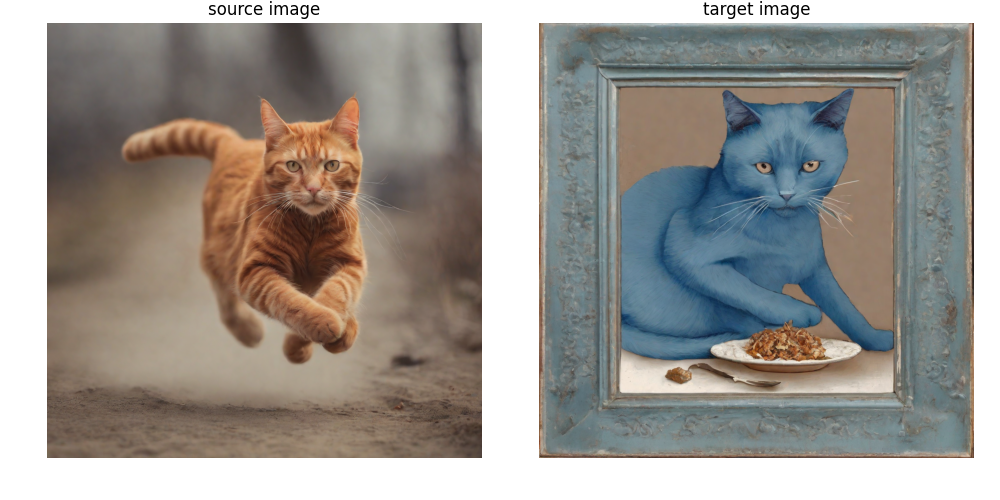

{'norm': 386.86248779296875, 'max': 49.35888671875, 'min': -87.783203125}

{'shape': torch.Size([1, 1280]),
 'mean': -0.0013591430615633726,
 'std': 0.027928698807954788,
 'values': array([[-0.00961085, -0.01597907,  0.00504516, ...,  0.01766878,
          0.00682314, -0.00824859]], dtype=float32)}

'Target image 1: Max cosine similarity = 0.7371 at (320, 538)'

0.9246151

In [ ]:
import torch
import torch.nn.functional as F
from dift_unet_sdxl_ip_adapter import Dift_UNet2DConditionModel
from utils.general_utils import gaussian_smooth
from src.utils.visualization import Demo
torch.cuda.set_device(0)
from diffusers import UNet2DConditionModel
from diffusers import StableDiffusionXLPipeline
from diffusers import DDIMScheduler

def load_pipeline():
    float_type = torch.float16
    sd_id = "stable-diffusion-xl-base-1.0/"
    
    device = "cuda"
    unet = Dift_UNet2DConditionModel.from_pretrained(sd_id, subfolder="unet", torch_dtype=float_type)
    scheduler = DDIMScheduler.from_pretrained(sd_id, subfolder="scheduler")

    pipeline = StableDiffusionXLPipeline.from_pretrained(
        sd_id, unet=unet, torch_dtype=float_type, variant="fp16", use_safetensors=True, scheduler=scheduler
    ).to(device)
    
    return pipeline

pipe = load_pipeline()

prompts = [
    "a photo of a red cat runing",
    "a photo of a blue cat eating"
]
batch_size = len(prompts)
n_steps = 50
downscale_rate = 4
concept_token = "car"

do_smooth = True 

out = pipe(
    prompt=prompts,
    num_inference_steps=n_steps,
)
images = out.images

raw_feats = pipe.unet.dift_latent_store.dift_features["261_0"]
if raw_feats.shape[0] == 2 * batch_size:
    raw_feats = raw_feats[batch_size:]

if do_smooth:
    feats = torch.stack(
        [gaussian_smooth(f, kernel_size=3, sigma=1) for f in raw_feats],
        dim=0
    )
else:
    feats = raw_feats

feat_size = images[0].size[0] // downscale_rate
ft = F.interpolate(
    feats, size=(feat_size, feat_size),
    mode="bilinear", align_corners=False
)  # [B, C, feat_size, feat_size]

print(images[0].size, ft.shape)
orig_size = images[0].size[0]

demo = Demo(images, ft, orig_size)
demo.plot_img_pairs(fig_size=5)

